# Predict Ab downfall

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import random
import os
sys.path.append("..")
from global_variables import *
from escape_map import EscapeMap, load_escape_map_from_csv,gen_artif_data, score_seq_batch
from utils import get_Kd

E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors


In [2]:
#import utils from ../rbm
pgm_dir=('../')
sys.path.append(pgm_dir+'./utilities')

# Now safe to import
import utilities, Proteins_utils, sequence_logo, plots_utils
import rbm, RBM_utils  # rbm.py must be alongside this file

# Escape Score

In [3]:
seqs=Proteins_utils.load_FASTA('generated_sequences_beta3.fasta', drop_duplicates=False)
seqs.shape


(1000, 178)

In [4]:
log_kd_values=np.array([get_Kd(seq,BA1_KD_VECTORS , log10=True) for seq in seqs])

ace2_rbm_scores=pd.read_csv('generated_sequences_scores_beta3.csv')['score'].values
log_kd_values.shape#nseeq, n_ab


(1000, 671)

In [5]:
ab_names=list(BA1_KD_VECTORS.keys())
ab_names

['BD56-001',
 'BD56-003',
 'BD56-004',
 'BD56-005',
 'BD56-006',
 'BD56-007',
 'BD56-008',
 'BD56-010',
 'BD56-012',
 'BD56-013',
 'BD56-014',
 'BD56-015',
 'BD56-016',
 'BD56-019',
 'BD56-020',
 'BD56-021',
 'BD56-022',
 'BD56-025',
 'BD56-027',
 'BD56-028',
 'BD56-029',
 'BD56-030',
 'BD56-031',
 'BD56-032',
 'BD56-033',
 'BD56-037',
 'BD56-038',
 'BD56-039',
 'BD56-040',
 'BD56-041',
 'BD56-042',
 'BD56-045',
 'BD56-046',
 'BD56-048',
 'BD56-049',
 'BD56-050',
 'BD56-052',
 'BD56-054',
 'BD56-055',
 'BD56-056',
 'BD56-057',
 'BD56-058',
 'BD56-059',
 'BD56-063',
 'BD56-064',
 'BD56-065',
 'BD56-066',
 'BD56-068',
 'BD56-069',
 'BD56-070',
 'BD56-071',
 'BD56-073',
 'BD56-074',
 'BD56-075',
 'BD56-076',
 'BD56-077',
 'BD56-078',
 'BD56-079',
 'BD56-080',
 'BD56-081',
 'BD56-082',
 'BD56-083',
 'BD56-085',
 'BD56-086',
 'BD56-087',
 'BD56-088',
 'BD56-089',
 'BD56-090',
 'BD56-091',
 'BD56-092',
 'BD56-094',
 'BD56-096',
 'BD56-097',
 'BD56-098',
 'BD56-099',
 'BD56-100',
 'BD56-101',

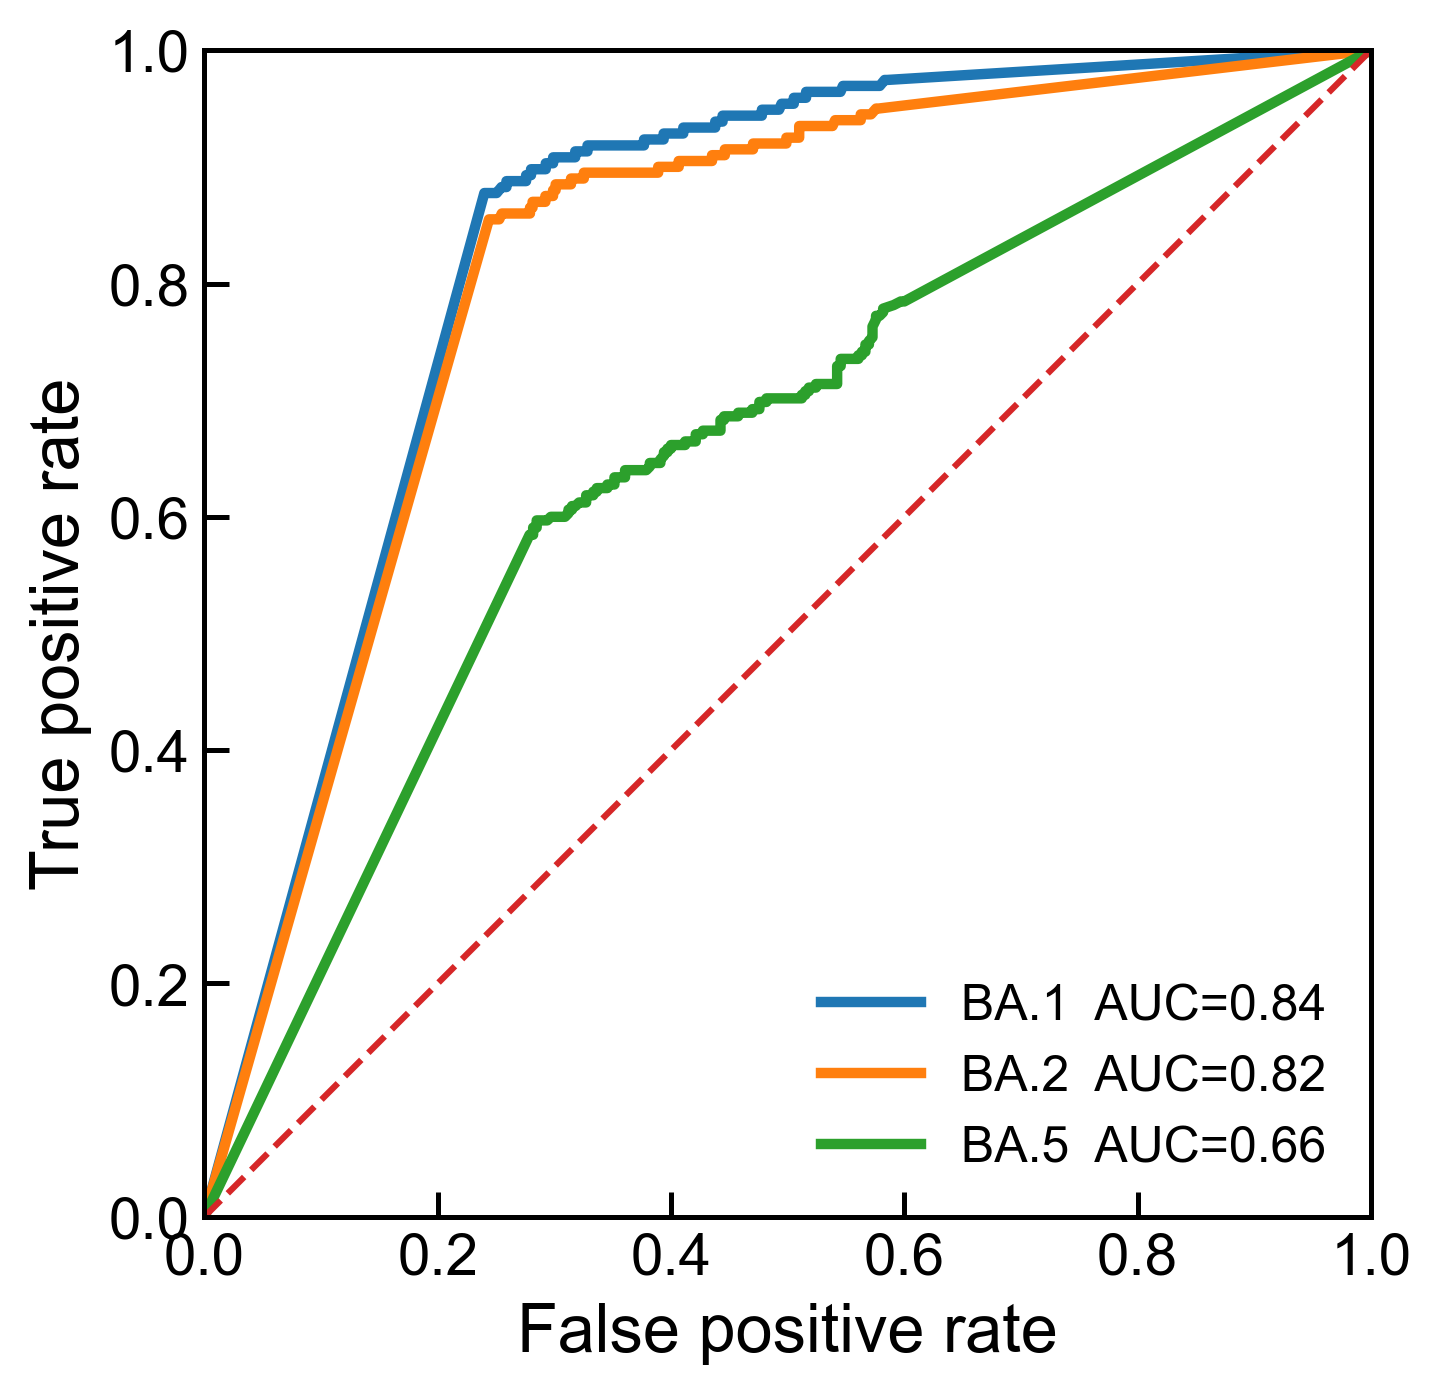

  virus       AUC
0  BA.1  0.836267
1  BA.2  0.817819
2  BA.5  0.655776


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

TH = -6.0  # threshold on log10 Kd

# Fm per antibody from log_kd_values (shape: n_seq x n_ab)
fm_df = pd.DataFrame({
    'antibody': ab_names,
    'Fm': (log_kd_values > TH).mean(axis=0)
})

# Binary escape labels from IC50
ic50_db = ic50_db.copy()
ic50_db['escape'] = (np.isclose(ic50_db['IC50'], 10.0) | (ic50_db['IC50'] >= 10.0)).astype(int)

# --- publication styling (call once before plotting) ---
import matplotlib as mpl
mpl.rcParams.update({
    'figure.dpi': 300,
    'savefig.dpi': 600,
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 16,
    'legend.fontsize': 12,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'axes.linewidth': 1.2,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'pdf.fonttype': 42,   # editable text in Illustrator
    'ps.fonttype': 42,
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Helvetica']
})

# --- your plotting block with enhancements ---
plt.figure(figsize=(5,5))
aucs = []
ic50_db_grouped = ic50_db.groupby('virus')

for virus in ['BA.1', 'BA.2', 'BA.5']:
    dfv = ic50_db_grouped.get_group(virus)
    lab = dfv.groupby('antibody')['escape'].max().reset_index()
    merged = lab.merge(fm_df, on='antibody', how='inner')
    if merged['escape'].nunique() < 2:
        continue

    y_true = merged['escape'].values.astype(int)
    y_score = merged['Fm'].values.astype(float)

    fpr, tpr, _ = roc_curve(y_true, y_score)
    A = auc(fpr, tpr)
    aucs.append((virus, A))

    plt.plot(fpr, tpr, lw=2.5, label=f'{virus}  AUC={A:.2f}')

# baseline
plt.plot([0,1],[0,1], linestyle='--', lw=1.5)

# axes and layout
ax = plt.gca()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal', 'box')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
# ax.set_title('ROC: Fm(ab) vs IC50 escape per virus')
# for spine in ['top','right']:
#     ax.spines[spine].set_visible(False)
ax.grid(False)
ax.legend(loc='lower right', frameon=False)

plt.tight_layout()
plt.show()

# optional: save high-quality copies


# optional: AUC table
auc_table = pd.DataFrame(aucs, columns=['virus','AUC']).sort_values('AUC', ascending=False)
print(auc_table)


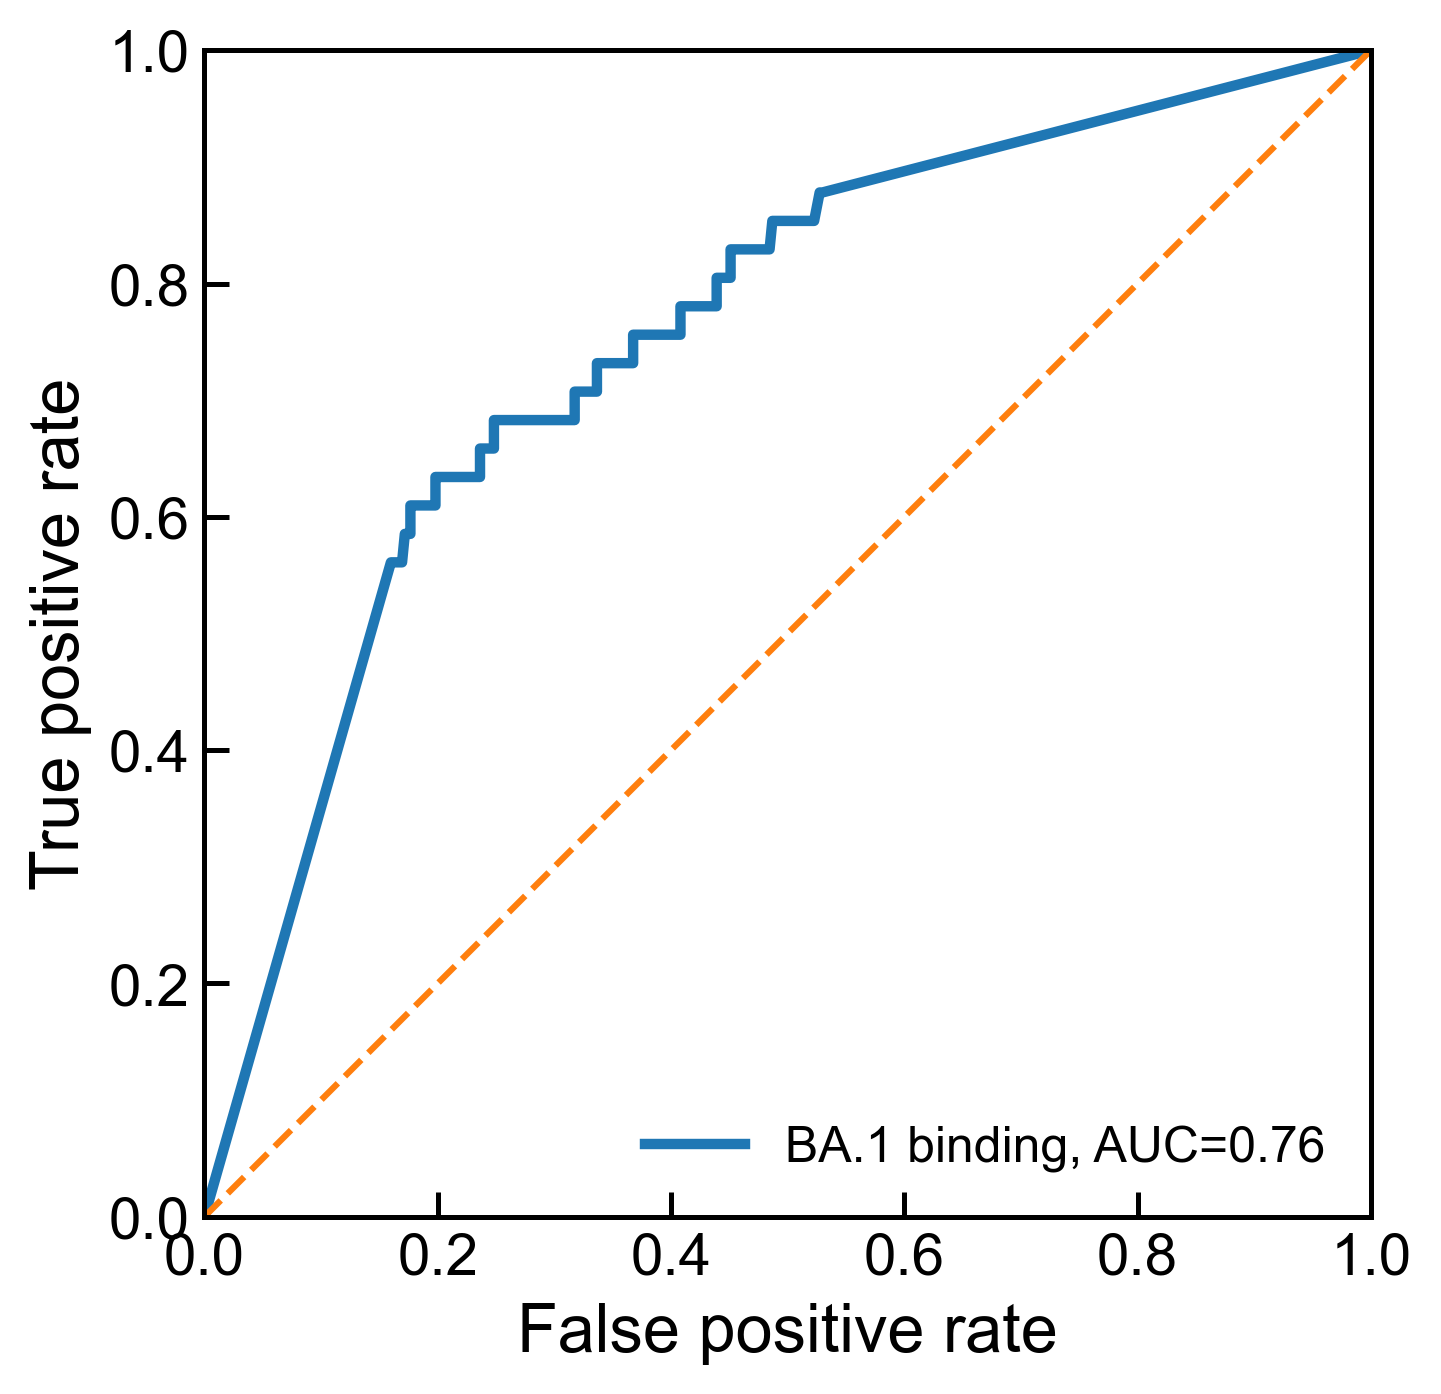

Excluded antibodies (D614G IC50==10.0): 1761
['7D6', 'BD-695', 'BD-732', 'BD-821', 'BD-828', 'BD-846', 'BD-849', 'BD-863', 'BD55-1028', 'BD55-1034', 'BD55-1038', 'BD55-1066', 'BD55-1070', 'BD55-1087', 'BD55-1093', 'BD55-1128', 'BD55-1132', 'BD55-1140', 'BD55-1141', 'BD55-1144', 'BD55-1145', 'BD55-1162', 'BD55-1179', 'BD55-1211', 'BD55-1214', 'BD55-1242', 'BD55-1257', 'BD55-1270', 'BD55-1275', 'BD55-1278', 'BD55-1332', 'BD55-1341', 'BD55-1345', 'BD55-1391', 'BD55-1396', 'BD55-1445', 'BD55-1464', 'BD55-1499', 'BD55-1507', 'BD55-1604', 'BD55-1811', 'BD55-199', 'BD55-2101', 'BD55-2314', 'BD55-2413', 'BD55-3150', 'BD55-3151', 'BD55-3161', 'BD55-319', 'BD55-3300', 'BD55-3324', 'BD55-3366', 'BD55-3367', 'BD55-3417', 'BD55-3549', 'BD55-3561', 'BD55-3670', 'BD55-3684', 'BD55-3741', 'BD55-3807', 'BD55-389', 'BD55-4286', 'BD55-4329', 'BD55-4356', 'BD55-4359', 'BD55-4360', 'BD55-4364', 'BD55-4392', 'BD55-4394', 'BD55-4467', 'BD55-4707', 'BD55-4804', 'BD55-5166', 'BD55-5176', 'BD55-5205', 'BD55-523

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl

TH = -6.0  # threshold on log10 Kd

# Fm per antibody from log_kd_values (shape: n_seq x n_ab)
fm_df = pd.DataFrame({'antibody': ab_names, 'Fm': (log_kd_values > TH).mean(axis=0)})

# Binary escape labels from IC50
ic50_db = ic50_db.copy()
ic50_db['escape'] = ((ic50_db['IC50'] >= 10.0) | np.isclose(ic50_db['IC50'], 10.0)).astype(int)

# EXCLUDE antibodies with D614G IC50 == 10.0
exclude_abs = set(ic50_db[(ic50_db['virus'] == 'D614G') & (ic50_db['IC50'] == 10.0)]['antibody'].unique())
fm_keep = fm_df[~fm_df['antibody'].isin(exclude_abs)].copy()

# publication styling
mpl.rcParams.update({
    'figure.dpi': 300, 'savefig.dpi': 600, 'font.size': 14,
    'axes.titlesize': 16, 'axes.labelsize': 16, 'legend.fontsize': 12,
    'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.linewidth': 1.2,
    'xtick.major.size': 6, 'ytick.major.size': 6, 'xtick.major.width': 1.2,
    'ytick.major.width': 1.2, 'xtick.direction': 'in', 'ytick.direction': 'in',
    'pdf.fonttype': 42, 'ps.fonttype': 42, 'font.sans-serif': ['Arial','DejaVu Sans','Helvetica']
})

plt.figure(figsize=(5,5))
aucs = []
ic50_db_grouped = ic50_db.groupby('virus')

for virus in ['BA.1']:
    if virus not in ic50_db_grouped.groups:
        continue
    dfv = ic50_db_grouped.get_group(virus)

    # one label per antibody for this virus: escape if any replicate escaped
    lab = dfv.groupby('antibody')['escape'].max().reset_index()
    lab = lab[~lab['antibody'].isin(exclude_abs)]  # drop excluded antibodies

    merged = lab.merge(fm_keep, on='antibody', how='inner')
    if merged['escape'].nunique() < 2:
        continue  # ROC undefined if only one class

    y_true = merged['escape'].values.astype(int)
    y_score = merged['Fm'].values.astype(float)

    fpr, tpr, _ = roc_curve(y_true, y_score)
    A = auc(fpr, tpr)
    aucs.append((virus, A))
    plt.plot(fpr, tpr, lw=2.5, label=f'{virus} binding, AUC={A:.2f}')

# baseline
plt.plot([0,1],[0,1], linestyle='--', lw=1.5)

ax = plt.gca()
ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_aspect('equal', 'box')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.legend(loc='lower right', frameon=False)
plt.tight_layout()
plt.show()

# optional
print(f'Excluded antibodies (D614G IC50==10.0): {len(exclude_abs)}')
print(sorted(exclude_abs))
auc_table = pd.DataFrame(aucs, columns=['virus','AUC']).sort_values('AUC', ascending=False)
print(auc_table)
